# Compare training logs (6 models)

This notebook reads `train_*.log` files (e.g., `train_resnet18.log`) and produces:
- Validation MAE by epoch (all models)
- Validation RMSE by epoch (all models)
- Bar chart of best validation MAE per model

It also prints a small summary table with the best epoch/metrics per model.


In [1]:
from __future__ import annotations

import re
import codecs
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

EPOCH_RE = re.compile(
    r"Epoch\s+(\d+)\s+\|\s+Train Loss:\s+([0-9.]+)\s+\|\s+Val MAE:\s+([0-9.]+)\s+\|\s+Val RMSE:\s+([0-9.]+)"
)

def read_text_auto(path: Path) -> str:
    """Robust log reader: handles UTF-16 logs (PowerShell redirection) and UTF-8."""
    data = path.read_bytes()
    if data.startswith(codecs.BOM_UTF16_LE) or data.startswith(codecs.BOM_UTF16_BE):
        return data.decode("utf-16")
    if data.count(b"\x00") > len(data) * 0.1:
        try:
            return data.decode("utf-16")
        except UnicodeError:
            return data.decode("utf-16-le", errors="ignore")
    return data.decode("utf-8", errors="ignore")

def stem_to_label(stem: str) -> str:
    s = stem
    if s.startswith("train_"):
        s = s[len("train_"):]
    return s

def parse_log(path: Path) -> pd.DataFrame:
    txt = read_text_auto(path)
    rows = []
    for line in txt.splitlines():
        m = EPOCH_RE.search(line)
        if m:
            rows.append((int(m.group(1)), float(m.group(2)), float(m.group(3)), float(m.group(4))))
    df = pd.DataFrame(rows, columns=["epoch", "train_loss", "val_mae", "val_rmse"]).sort_values("epoch")
    if df.empty:
        raise ValueError(f"No epoch lines parsed from: {path}")
    return df


## Configuration

Set `log_dir` to your folder with the `.log` files. You can use a relative path (recommended) or an absolute Windows path.


In [2]:
# Option A (recommended): relative paths from repo root
log_dir = Path("data/preds/logs")
out_dir = Path("data/preds/plots")

# Option B: absolute Windows path (uncomment and adjust)
# log_dir = Path(r"C:\\Users\\matia\\OneDrive\\Desktop\\Data Science Master\\2.- FIRST SEMESTER\\DATA SCIENCE\\yelp-prediction\\data\\preds\\logs")
# out_dir = Path(r"C:\\Users\\matia\\OneDrive\\Desktop\\Data Science Master\\2.- FIRST SEMESTER\\DATA SCIENCE\\yelp-prediction\\data\\preds\\plots")

glob_pattern = "train_*.log"

# Optional: pretty labels
pretty = {
    "clip": "CLIP",
    "resnet18": "ResNet18",
    "resnet50": "ResNet50",
    "resnet152": "ResNet152",
    "vgg19": "VGG19",
    "vit_b_16": "ViT-B/16",
}


## Load and parse logs


In [5]:
from pathlib import Path

log_dir = Path("../../data/preds/logs")
out_dir = Path("../../data/preds/plots")
glob_pattern = "train_*.log"


In [6]:
from pathlib import Path

def find_repo_root(start: Path | None = None) -> Path:
    start = start or Path.cwd()
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists() or (p / ".git").exists():
            return p
    return start

ROOT = find_repo_root()
log_dir = ROOT / "data" / "preds" / "logs"
out_dir = ROOT / "data" / "preds" / "plots"
glob_pattern = "train_*.log"

print("CWD =", Path.cwd())
print("ROOT =", ROOT)
print("log_dir =", log_dir, "exists?", log_dir.exists())
print("found logs:", [x.name for x in log_dir.glob(glob_pattern)])


CWD = c:\Users\matia\OneDrive\Desktop\Data Science Master\2.- FIRST SEMESTER\DATA SCIENCE\yelp-prediction\src\yelp_prediction
ROOT = c:\Users\matia\OneDrive\Desktop\Data Science Master\2.- FIRST SEMESTER\DATA SCIENCE\yelp-prediction
log_dir = c:\Users\matia\OneDrive\Desktop\Data Science Master\2.- FIRST SEMESTER\DATA SCIENCE\yelp-prediction\data\preds\logs exists? True
found logs: ['train_clip.log', 'train_resnet152.log', 'train_resnet18.log', 'train_resnet50.log', 'train_vgg19.log', 'train_vit_b_16.log']


In [7]:
from pathlib import Path

def find_repo_root(start: Path | None = None) -> Path:
    start = start or Path.cwd()
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists() or (p / ".git").exists():
            return p
    return start

ROOT = find_repo_root()
log_dir = ROOT / "data" / "preds" / "logs"
out_dir = ROOT / "data" / "preds" / "plots"
glob_pattern = "train_*.log"


In [8]:
log_files = sorted(log_dir.glob(glob_pattern))
if not log_files:
    raise FileNotFoundError(f"No logs found with pattern='{glob_pattern}' in: {log_dir}")

dfs = {}
for f in log_files:
    raw_label = stem_to_label(f.stem)
    label = pretty.get(raw_label, raw_label)
    dfs[label] = parse_log(f)

list(dfs.keys())

['CLIP', 'ResNet152', 'ResNet18', 'ResNet50', 'VGG19', 'ViT-B/16']

## Best epoch summary (per model)


In [9]:
best_rows = []
for model, df in dfs.items():
    best = df.loc[df["val_mae"].idxmin()]
    best_rows.append({
        "model": model,
        "best_epoch": int(best["epoch"]),
        "best_val_mae": float(best["val_mae"]),
        "best_val_rmse": float(best["val_rmse"]),
    })

best_df = pd.DataFrame(best_rows).sort_values("best_val_mae").reset_index(drop=True)
best_df

,model,best_epoch,best_val_mae,best_val_rmse
0,CLIP,8,0.3806,0.4977
1,VGG19,12,0.3911,0.5171
2,ResNet152,3,0.3972,0.5229
3,ViT-B/16,3,0.4048,0.5335
4,ResNet50,5,0.4074,0.5332
5,ResNet18,16,0.4104,0.5406


## Plot: Validation MAE by epoch


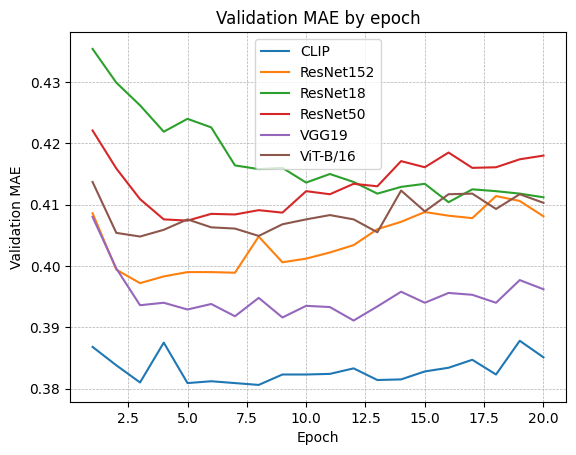

WindowsPath('c:/Users/matia/OneDrive/Desktop/Data Science Master/2.- FIRST SEMESTER/DATA SCIENCE/yelp-prediction/data/preds/plots/compare_val_mae.png')

In [10]:
plt.figure()
for model, df in dfs.items():
    plt.plot(df["epoch"], df["val_mae"], label=model)
plt.xlabel("Epoch")
plt.ylabel("Validation MAE")
plt.title("Validation MAE by epoch")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

out_dir.mkdir(parents=True, exist_ok=True)
mae_path = out_dir / "compare_val_mae.png"
plt.savefig(mae_path, dpi=200, bbox_inches="tight")
plt.show()

mae_path

## Plot: Validation RMSE by epoch


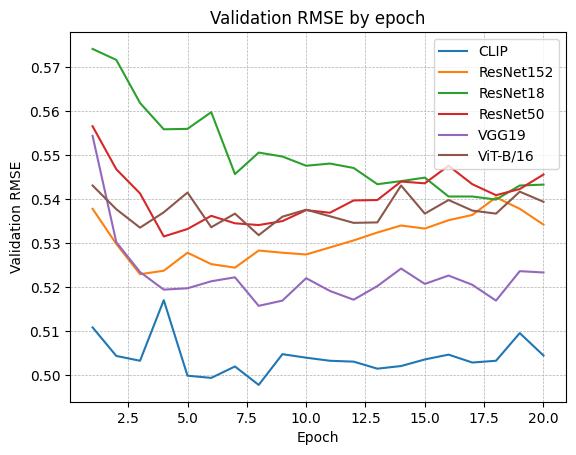

WindowsPath('c:/Users/matia/OneDrive/Desktop/Data Science Master/2.- FIRST SEMESTER/DATA SCIENCE/yelp-prediction/data/preds/plots/compare_val_rmse.png')

In [11]:
plt.figure()
for model, df in dfs.items():
    plt.plot(df["epoch"], df["val_rmse"], label=model)
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE by epoch")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

rmse_path = out_dir / "compare_val_rmse.png"
plt.savefig(rmse_path, dpi=200, bbox_inches="tight")
plt.show()

rmse_path

## Plot: Best validation MAE per model (bar)


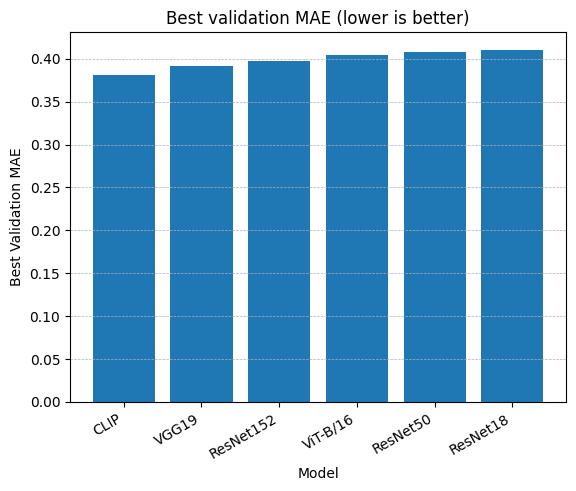

WindowsPath('c:/Users/matia/OneDrive/Desktop/Data Science Master/2.- FIRST SEMESTER/DATA SCIENCE/yelp-prediction/data/preds/plots/best_val_mae_bar.png')

In [12]:
plt.figure()
plt.bar(best_df["model"], best_df["best_val_mae"])
plt.xlabel("Model")
plt.ylabel("Best Validation MAE")
plt.title("Best validation MAE (lower is better)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)

bar_path = out_dir / "best_val_mae_bar.png"
plt.savefig(bar_path, dpi=200, bbox_inches="tight")
plt.show()

bar_path

## Notes
- If your logs have a different line format, adjust `EPOCH_RE` accordingly.
- This notebook intentionally avoids seaborn and custom colors (plain matplotlib) for portability.


In [13]:
import json
import pandas as pd
from pathlib import Path

def parse_run_json(path: Path) -> pd.DataFrame:
    obj = json.loads(path.read_text(encoding="utf-8"))
    hist = obj.get("history", [])
    if not hist:
        raise ValueError(f"No 'history' found in: {path}")

    df = pd.DataFrame(hist)
    # Normaliza nombres esperados
    rename = {
        "epoch": "epoch",
        "train_loss": "train_loss",
        "val_mae": "val_mae",
        "val_rmse": "val_rmse",
    }
    df = df.rename(columns=rename)

    needed = {"epoch", "train_loss", "val_mae", "val_rmse"}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns {missing} in history for: {path}")

    return df.sort_values("epoch").reset_index(drop=True)


In [14]:
clip_log = log_dir / "train_clip.log"
ft_json  = log_dir / "run_ftlast2_clip__mlp__dims1024-512__actgelu__drop0.3__lrH0.0005__lrB5e-06__seed42__final_last2_5ppb_bs32.json"

df_clip = parse_log(clip_log)
df_ft   = parse_run_json(ft_json)

# Resumen best-epoch (por MAE)
def best_summary(name, df):
    i = df["val_mae"].idxmin()
    return {
        "model": name,
        "best_epoch": int(df.loc[i, "epoch"]),
        "best_val_mae": float(df.loc[i, "val_mae"]),
        "best_val_rmse": float(df.loc[i, "val_rmse"]),
    }

summary = pd.DataFrame([
    best_summary("CLIP (train_clip.log)", df_clip),
    best_summary("CLIP FT last2 (run_*.json)", df_ft),
]).sort_values("best_val_mae")

summary


,model,best_epoch,best_val_mae,best_val_rmse
1,CLIP FT last2 (run_*.json),3,0.374803,0.497188
0,CLIP (train_clip.log),8,0.380600,0.497700


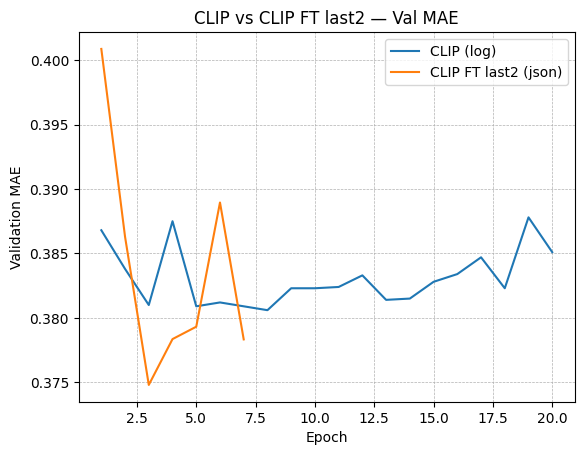

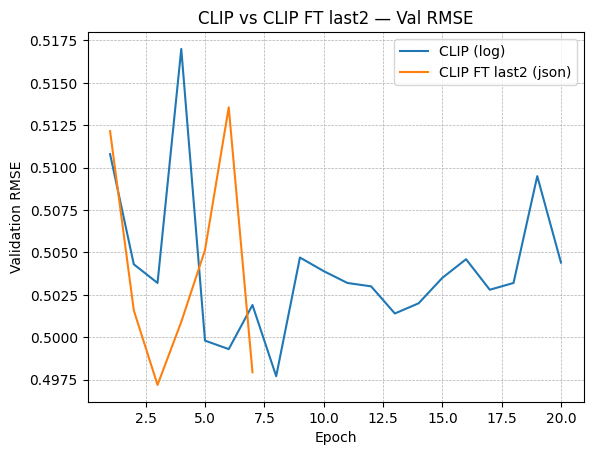

(WindowsPath('c:/Users/matia/OneDrive/Desktop/Data Science Master/2.- FIRST SEMESTER/DATA SCIENCE/yelp-prediction/data/preds/plots/compare_clip_vs_ftlast2_val_mae.png'),
 WindowsPath('c:/Users/matia/OneDrive/Desktop/Data Science Master/2.- FIRST SEMESTER/DATA SCIENCE/yelp-prediction/data/preds/plots/compare_clip_vs_ftlast2_val_rmse.png'))

In [15]:
import matplotlib.pyplot as plt

out_dir.mkdir(parents=True, exist_ok=True)

# MAE
plt.figure()
plt.plot(df_clip["epoch"], df_clip["val_mae"], label="CLIP (log)")
plt.plot(df_ft["epoch"],   df_ft["val_mae"],   label="CLIP FT last2 (json)")
plt.xlabel("Epoch")
plt.ylabel("Validation MAE")
plt.title("CLIP vs CLIP FT last2 — Val MAE")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
mae_path = out_dir / "compare_clip_vs_ftlast2_val_mae.png"
plt.savefig(mae_path, dpi=200, bbox_inches="tight")
plt.show()

# RMSE
plt.figure()
plt.plot(df_clip["epoch"], df_clip["val_rmse"], label="CLIP (log)")
plt.plot(df_ft["epoch"],   df_ft["val_rmse"],   label="CLIP FT last2 (json)")
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("CLIP vs CLIP FT last2 — Val RMSE")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
rmse_path = out_dir / "compare_clip_vs_ftlast2_val_rmse.png"
plt.savefig(rmse_path, dpi=200, bbox_inches="tight")
plt.show()

mae_path, rmse_path


In [16]:
MAX_EPOCH = 8

df_clip_8 = df_clip[df_clip["epoch"] <= MAX_EPOCH].copy()
df_ft_8   = df_ft[df_ft["epoch"]   <= MAX_EPOCH].copy()


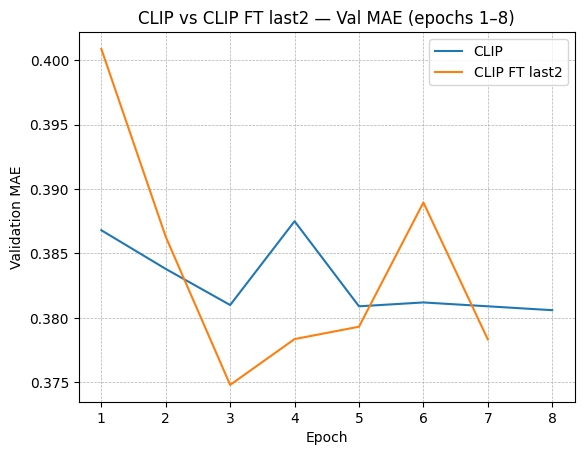

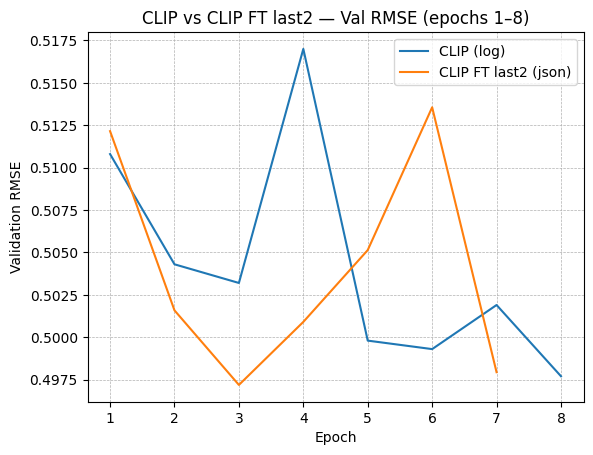

In [24]:
# MAE
plt.figure()
plt.plot(df_clip_8["epoch"], df_clip_8["val_mae"], label="CLIP")
plt.plot(df_ft_8["epoch"],   df_ft_8["val_mae"],   label="CLIP FT last2")
plt.xlabel("Epoch")
plt.ylabel("Validation MAE")
plt.title("CLIP vs CLIP FT last2 — Val MAE (epochs 1–8)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
mae_path = out_dir / "compare_clip_vs_ftlast2_val_mae_e1-8.png"
plt.savefig(mae_path, dpi=200, bbox_inches="tight")
plt.show()

# RMSE
plt.figure()
plt.plot(df_clip_8["epoch"], df_clip_8["val_rmse"], label="CLIP (log)")
plt.plot(df_ft_8["epoch"],   df_ft_8["val_rmse"],   label="CLIP FT last2 (json)")
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("CLIP vs CLIP FT last2 — Val RMSE (epochs 1–8)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
rmse_path = out_dir / "compare_clip_vs_ftlast2_val_rmse_e1-8.png"
plt.savefig(rmse_path, dpi=200, bbox_inches="tight")
plt.show()


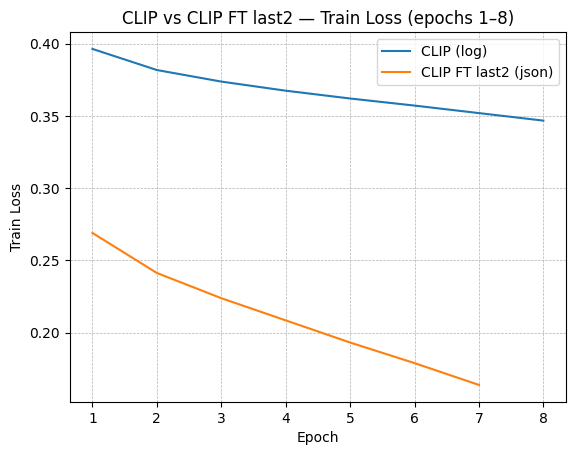

WindowsPath('c:/Users/matia/OneDrive/Desktop/Data Science Master/2.- FIRST SEMESTER/DATA SCIENCE/yelp-prediction/data/preds/plots/compare_clip_vs_ftlast2_train_loss_e1-8.png')

In [19]:
def get_loss_col(df):
    for c in ["train_loss", "loss"]:
        if c in df.columns:
            return c
    raise ValueError(f"No loss column found. Available columns: {list(df.columns)}")

loss_clip = get_loss_col(df_clip_8)
loss_ft   = get_loss_col(df_ft_8)

plt.figure()
plt.plot(df_clip_8["epoch"], df_clip_8[loss_clip], label="CLIP (log)")
plt.plot(df_ft_8["epoch"],   df_ft_8[loss_ft],     label="CLIP FT last2 (json)")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("CLIP vs CLIP FT last2 — Train Loss (epochs 1–8)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
loss_path = out_dir / "compare_clip_vs_ftlast2_train_loss_e1-8.png"
plt.savefig(loss_path, dpi=200, bbox_inches="tight")
plt.show()

loss_path


In [20]:
import json
import pandas as pd
from pathlib import Path

def find_repo_root(start: Path | None = None) -> Path:
    start = start or Path.cwd()
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists() or (p / ".git").exists():
            return p
    return start

ROOT = find_repo_root()
runs_dir = ROOT / "data" / "try_enhance" / "runs"

run_files = sorted(runs_dir.glob("run_*.json"))
if not run_files:
    raise FileNotFoundError(f"No run_*.json found in {runs_dir}")

rows = []
for f in run_files:
    obj = json.loads(f.read_text(encoding="utf-8"))
    cfg = obj.get("config", {})
    best = obj.get("best_val", {})

    row = {"run_file": f.name}
    # id legible
    row["run_name"] = cfg.get("run_name", f.stem)

    # métricas
    row["best_mae"] = best.get("mae", None)
    row["best_rmse"] = best.get("rmse", None)

    # flatten config (te deja columnas tipo cfg_lr, cfg_dropout, etc.)
    for k, v in cfg.items():
        row[f"cfg_{k}"] = v

    # paths (útiles para abrir preds después)
    row["model_path"] = obj.get("model_path", None)
    row["pred_path"]  = obj.get("pred_path", None)

    rows.append(row)

df = pd.DataFrame(rows)

# orden por MAE y luego RMSE
leaderboard = df.sort_values(["best_mae", "best_rmse"], ascending=True).reset_index(drop=True)
leaderboard[["run_name","best_mae","best_rmse","cfg_loss","cfg_optimizer","cfg_lr","cfg_weight_decay","cfg_dropout","cfg_l2norm","cfg_batch_size"]].head(20)


,run_name,best_mae,best_rmse,cfg_loss,cfg_optimizer,cfg_lr,cfg_weight_decay,cfg_dropout,cfg_l2norm,cfg_batch_size
0,sweepquick_20251217_233110__026,0.380113,0.500327,mae,adamw,0.0010,0.01,0.3,False,128
1,sweepquick_20251217_233110__021,0.380574,0.494766,mse,adamw,0.0005,0.01,0.2,False,128
2,sweepquick_20251217_233110__016,0.380713,0.497034,mse,adam,0.0010,0.00,0.3,False,128
3,sweepquick_20251217_233110__010,0.380854,0.502953,mae,adamw,0.0010,0.01,0.3,False,128
4,sweepquick_20251217_233110__011,0.381068,0.500593,mae,adam,0.0005,0.00,0.3,False,128
5,sweepquick_20251217_233110__032,0.381090,0.496650,mse,adam,0.0010,0.00,0.3,False,128
6,sweepquick_20251217_233110__012,0.381217,0.501428,mae,adam,0.0010,0.00,0.3,False,128
7,sweepquick_20251217_233110__024,0.381265,0.495780,mse,adam,0.0010,0.00,0.2,False,128
8,clip__headmlp__dims1024-512__actgelu__do0p3__b...,0.381366,0.502182,mae,adamw,0.0005,0.01,0.3,False,128
9,sweepquick_20251217_233110__009,0.381366,0.502182,mae,adamw,0.0005,0.01,0.3,False,128


In [21]:
out_csv = ROOT / "data" / "try_enhance" / "runs_leaderboard.csv"
leaderboard.to_csv(out_csv, index=False)
out_csv


WindowsPath('c:/Users/matia/OneDrive/Desktop/Data Science Master/2.- FIRST SEMESTER/DATA SCIENCE/yelp-prediction/data/try_enhance/runs_leaderboard.csv')

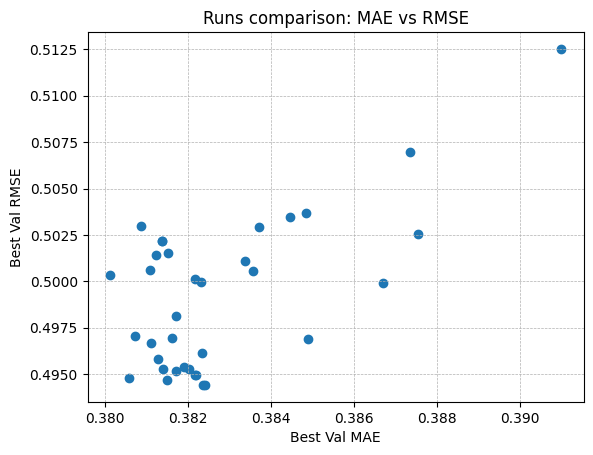

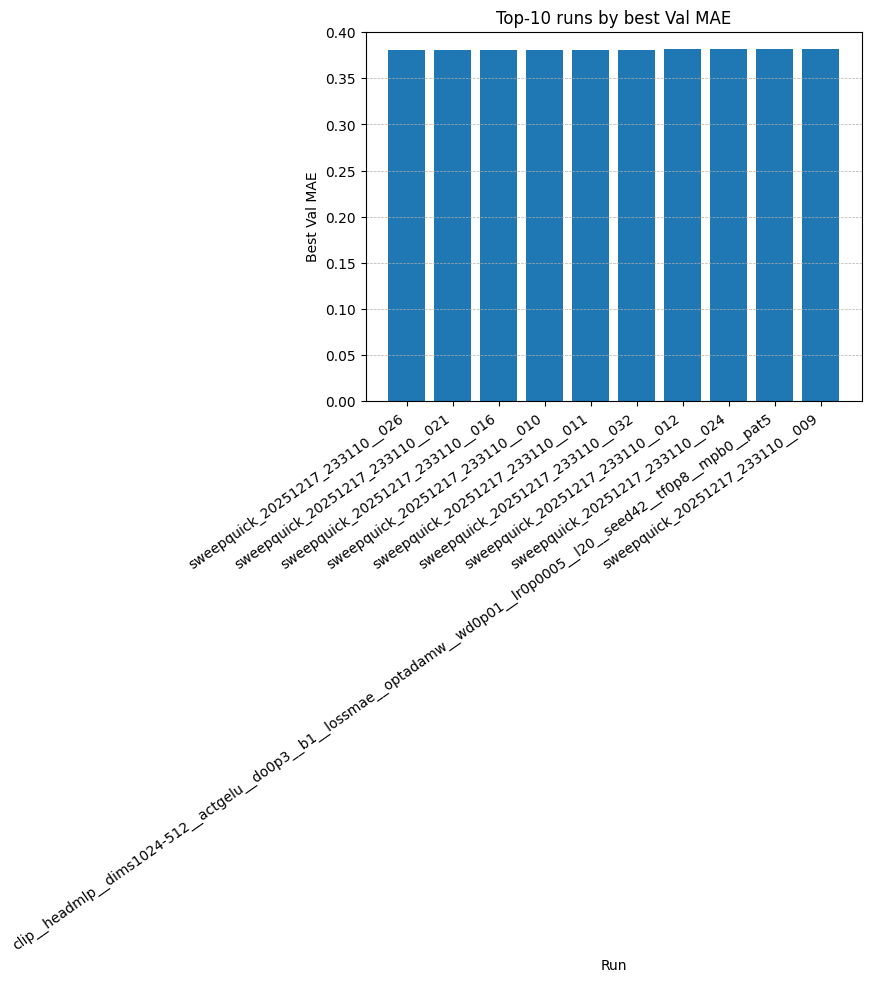

In [22]:
import matplotlib.pyplot as plt

# Scatter MAE vs RMSE
plt.figure()
plt.scatter(leaderboard["best_mae"], leaderboard["best_rmse"])
plt.xlabel("Best Val MAE")
plt.ylabel("Best Val RMSE")
plt.title("Runs comparison: MAE vs RMSE")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# Bar top-10 (menor MAE)
topk = leaderboard.head(10).copy()
plt.figure()
plt.bar(topk["run_name"], topk["best_mae"])
plt.xlabel("Run")
plt.ylabel("Best Val MAE")
plt.title("Top-10 runs by best Val MAE")
plt.xticks(rotation=35, ha="right")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.show()


In [23]:
# Resumen por optimizer/loss (media y mejor caso)
summary = (
    leaderboard
    .groupby(["cfg_optimizer","cfg_loss"], dropna=False)
    .agg(
        n=("run_name","count"),
        best_mae_min=("best_mae","min"),
        best_rmse_min=("best_rmse","min"),
        best_mae_mean=("best_mae","mean"),
    )
    .sort_values("best_mae_min")
)
summary.head(20)


n  best_mae_min  best_rmse_min  best_mae_mean
cfg_optimizer cfg_loss                                                
adamw         mae       10      0.380113       0.500123       0.383045
              mse        8      0.380574       0.494408       0.382208
adam          mse        8      0.380713       0.494413       0.381543
              mae        9      0.381068       0.498143       0.383967